In [1]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torchtoolbox.transform as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
import pandas as pd
import numpy as np
import gc
import os
import cv2
import time
import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from efficientnet_pytorch import EfficientNet
%matplotlib inline

## config(kernel使うときに変更すべき変数)

In [2]:
# config
melanoma_external_malignant_256 = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/melanoma_external_malignant_256/"
SIIM_ISIC_Melanoma_Classification = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/SIIM-ISIC-Melanoma-Classification/"
Output = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/Output/"

## 画像処理部

In [3]:
# At least fixing some random seeds. 
# It is still impossible to make results 100% reproducible when using GPU
warnings.simplefilter('ignore')
torch.manual_seed(47)
np.random.seed(47)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class MelanomaDataset(Dataset):
    def __init__(self, df: pd.DataFrame, imfolder: str, train: bool = True, transforms = None, meta_features = None):
        """
        Class initialization
        Args:
            df (pd.DataFrame): DataFrame with data description
            imfolder (str): folder with images
            train (bool): flag of whether a training dataset is being initialized or testing one
            transforms: image transformation method to be applied
            meta_features (list): list of features with meta information, such as sex and age
            
        """
        self.df = df
        self.imfolder = imfolder
        self.transforms = transforms
        self.train = train
        self.meta_features = meta_features
        
    def __getitem__(self, index):
        im_path = os.path.join(self.imfolder, self.df.iloc[index]['image_name'] + '.jpg')
        x = cv2.imread(im_path)
        meta = np.array(self.df.iloc[index][self.meta_features].values, dtype=np.float32)

        if self.transforms:
            x = self.transforms(x)
            
        if self.train:
            y = self.df.loc[index]['target']
            return (x, meta), y
        else:
            return (x, meta)
    
    def __len__(self):
        return len(self.df)
    
    
class Net(nn.Module):
    def __init__(self, arch, n_meta_features: int):
        super(Net, self).__init__()
        self.arch = arch
        if 'ResNet' in str(arch.__class__):
            self.arch.fc = nn.Linear(in_features=512, out_features=500, bias=True)
        if 'EfficientNet' in str(arch.__class__):
            self.arch._fc = nn.Linear(in_features=1280, out_features=500, bias=True)
        self.meta = nn.Sequential(nn.Linear(n_meta_features, 500),
                                  nn.BatchNorm1d(500),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2),
                                  nn.Linear(500, 250),  # FC layer output will have 50 features
                                  nn.BatchNorm1d(250),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2))
        self.ouput = nn.Linear(500 + 250, 1)
        
    def forward(self, inputs):
        """
        No sigmoid in forward because we are going to use BCEWithLogitsLoss
        Which applies sigmoid for us when calculating a loss
        """
        x, meta = inputs
        cnn_features = self.arch(x)
        meta_features = self.meta(meta)
        features = torch.cat((cnn_features, meta_features), dim=1)
        output = self.ouput(features)
        return output

In [6]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
    transforms.Cutout(scale=(0.05, 0.007), value=(0, 0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [7]:
arch = EfficientNet.from_pretrained('efficientnet-b1')  # Going to use efficientnet-b0 NN architecture
# skf = StratifiedKFold(n_splits=3, random_state=999, shuffle=True)
skf = GroupKFold(n_splits=5)

Loaded pretrained weights for efficientnet-b1


In [8]:
train_df = pd.read_csv(melanoma_external_malignant_256 + 'train_concat.csv')
test_df = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'test.csv')

In [9]:
# One-hot encoding of anatom_site_general_challenge feature
concat = pd.concat([train_df['anatom_site_general_challenge'], test_df['anatom_site_general_challenge']], ignore_index=True)
dummies = pd.get_dummies(concat, dummy_na=True, dtype=np.uint8, prefix='site')
train_df = pd.concat([train_df, dummies.iloc[:train_df.shape[0]]], axis=1)
test_df = pd.concat([test_df, dummies.iloc[train_df.shape[0]:].reset_index(drop=True)], axis=1)

# Sex features
train_df['sex'] = train_df['sex'].map({'male': 1, 'female': 0})
test_df['sex'] = test_df['sex'].map({'male': 1, 'female': 0})
train_df['sex'] = train_df['sex'].fillna(-1)
test_df['sex'] = test_df['sex'].fillna(-1)

# Age features
train_df['age_approx'] /= train_df['age_approx'].max()
test_df['age_approx'] /= test_df['age_approx'].max()
train_df['age_approx'] = train_df['age_approx'].fillna(0)
test_df['age_approx'] = test_df['age_approx'].fillna(0)

train_df['patient_id'] = train_df['patient_id'].fillna(0)

In [10]:
meta_features = ['sex', 'age_approx'] + [col for col in train_df.columns if 'site_' in col]
meta_features.remove('anatom_site_general_challenge')

In [11]:
test = MelanomaDataset(df=test_df,
                       imfolder = melanoma_external_malignant_256 + 'test/test/', 
                       train=False,
                       transforms=train_transform,
                       meta_features=meta_features)

In [12]:
%%time
epochs = 10  # Number of epochs to run
model_path = Output + 'model.pth'  # Path and filename to save model to
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds

oof = np.zeros((len(train_df), 1))  # Out Of Fold predictions
preds = torch.zeros((len(test), 1), dtype=torch.float32, device=device)  # Predictions for test test

# We stratify by target value, thus, according to sklearn StratifiedKFold documentation
# We can fill `X` with zeroes of corresponding length to use it as a placeholder
# since we only need `y` to stratify the data
# for fold, (train_idx, val_idx) in enumerate(skf.split(X=np.zeros(len(train_df)), y=train_df['target']), 1):
for fold, (train_idx, val_idx) in enumerate(skf.split(X=np.zeros(len(train_df)), y=train_df['target'], groups=train_df['patient_id'].tolist()), 1):
    print('=' * 20, 'Fold', fold, '=' * 20)
    
    best_val = None  # Best validation score within this fold
    patience = es_patience  # Current patience counter
    arch = EfficientNet.from_pretrained('efficientnet-b1')
    model = Net(arch=arch, n_meta_features=len(meta_features))  # New model for each fold
    model = model.to(device)
    
    
    optim = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer=optim, mode='max', patience=1, verbose=True, factor=0.2)
    criterion = nn.BCEWithLogitsLoss()
    
    train = MelanomaDataset(df=train_df.iloc[train_idx].reset_index(drop=True), 
                            imfolder= melanoma_external_malignant_256 + 'train/train/',  
                            train=True, 
                            transforms=train_transform,
                            meta_features=meta_features)
    val = MelanomaDataset(df=train_df.iloc[val_idx].reset_index(drop=True), 
                            imfolder= melanoma_external_malignant_256 + 'train/train/', 
                            train=True, 
                            transforms=test_transform,
                            meta_features=meta_features)
    
    train_loader = DataLoader(dataset=train, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(dataset=val, batch_size=16, shuffle=False, num_workers=2)
    test_loader = DataLoader(dataset=test, batch_size=16, shuffle=False, num_workers=2)
    
    for epoch in range(epochs):
        start_time = time.time()
        correct = 0
        epoch_loss = 0
        model.train()
        
        for x, y in train_loader:
            x[0] = torch.tensor(x[0], device=device, dtype=torch.float32)
            x[1] = torch.tensor(x[1], device=device, dtype=torch.float32)
            y = torch.tensor(y, device=device, dtype=torch.float32)
            optim.zero_grad()
            z = model(x)
            loss = criterion(z, y.unsqueeze(1))
            loss.backward()
            optim.step()
            pred = torch.round(torch.sigmoid(z))  # round off sigmoid to obtain predictions
            correct += (pred.cpu() == y.cpu().unsqueeze(1)).sum().item()  # tracking number of correctly predicted samples
            epoch_loss += loss.item()

            
        train_acc = correct / len(train_idx)

        model.eval()  # switch model to the evaluation mode
        val_preds = torch.zeros((len(val_idx), 1), dtype=torch.float32, device=device)
        with torch.no_grad():  # Do not calculate gradient since we are only predicting
            # Predicting on validation set
            for j, (x_val, y_val) in enumerate(val_loader):
                x_val[0] = torch.tensor(x_val[0], device=device, dtype=torch.float32)
                x_val[1] = torch.tensor(x_val[1], device=device, dtype=torch.float32)
                y_val = torch.tensor(y_val, device=device, dtype=torch.float32)
                z_val = model(x_val)
                val_pred = torch.sigmoid(z_val)
                val_preds[j*x_val[0].shape[0]:j*x_val[0].shape[0] + x_val[0].shape[0]] = val_pred
            val_acc = accuracy_score(train_df.iloc[val_idx]['target'].values, torch.round(val_preds.cpu()))
            val_roc = roc_auc_score(train_df.iloc[val_idx]['target'].values, val_preds.cpu())
            
            print('Epoch {:03}: | Loss: {:.3f} | Train acc: {:.3f} | Val acc: {:.3f} | Val roc_auc: {:.3f} | Training time: {}'.format(
            epoch + 1, 
            epoch_loss, 
            train_acc, 
            val_acc, 
            val_roc, 
            str(datetime.timedelta(seconds=time.time() - start_time))[:7]))
            
            scheduler.step(val_roc)
            # During the first iteration (first epoch) best validation is set to None
            if not best_val:
                best_val = val_roc  # So any validation roc_auc we have is the best one for now
                torch.save(model, model_path)  # Saving the model
                continue
                
            if val_roc >= best_val:
                best_val = val_roc
                patience = es_patience  # Resetting patience since we have new best validation accuracy
                torch.save(model, model_path)  # Saving current best model
            else:
                patience -= 1
                if patience == 0:
                    print('Early stopping. Best Val roc_auc: {:.3f}'.format(best_val))
                    break
                
    model = torch.load(model_path)  # Loading best model of this fold
    model.eval()  # switch model to the evaluation mode
    val_preds = torch.zeros((len(val_idx), 1), dtype=torch.float32, device=device)
    with torch.no_grad():
        # Predicting on validation set once again to obtain data for OOF
        for j, (x_val, y_val) in enumerate(val_loader):
            x_val[0] = torch.tensor(x_val[0], device=device, dtype=torch.float32)
            x_val[1] = torch.tensor(x_val[1], device=device, dtype=torch.float32)
            y_val = torch.tensor(y_val, device=device, dtype=torch.float32)
            z_val = model(x_val)
            val_pred = torch.sigmoid(z_val)
            val_preds[j*x_val[0].shape[0]:j*x_val[0].shape[0] + x_val[0].shape[0]] = val_pred
        oof[val_idx] = val_preds.cpu().numpy()
        
        # Predicting on test set
        for _ in range(TTA):
            for i, x_test in enumerate(test_loader):
                x_test[0] = torch.tensor(x_test[0], device=device, dtype=torch.float32)
                x_test[1] = torch.tensor(x_test[1], device=device, dtype=torch.float32)
                z_test = model(x_test)
                z_test = torch.sigmoid(z_test)
                preds[i*x_test[0].shape[0]:i*x_test[0].shape[0] + x_test[0].shape[0]] += z_test
        preds /= TTA
        
    del train, val, train_loader, val_loader, x, y, x_val, y_val
    gc.collect()
    
preds /= skf.n_splits

==================== Fold 1 ====================
Loaded pretrained weights for efficientnet-b1
Epoch 001: | Loss: 114.118 | Train acc: 0.965 | Val acc: 0.943 | Val roc_auc: 0.962 | Training time: 0:04:29
Epoch 002: | Loss: 89.910 | Train acc: 0.973 | Val acc: 0.930 | Val roc_auc: 0.965 | Training time: 0:04:30
Epoch 003: | Loss: 87.178 | Train acc: 0.974 | Val acc: 0.945 | Val roc_auc: 0.971 | Training time: 0:04:30
Epoch 004: | Loss: 81.887 | Train acc: 0.976 | Val acc: 0.947 | Val roc_auc: 0.965 | Training time: 0:04:30
Epoch 005: | Loss: 79.648 | Train acc: 0.976 | Val acc: 0.959 | Val roc_auc: 0.978 | Training time: 0:04:30
Epoch 006: | Loss: 78.084 | Train acc: 0.976 | Val acc: 0.949 | Val roc_auc: 0.975 | Training time: 0:04:30
Epoch 007: | Loss: 75.031 | Train acc: 0.977 | Val acc: 0.946 | Val roc_auc: 0.974 | Training time: 0:04:30
Epoch     7: reducing learning rate of group 0 to 2.0000e-04.
Epoch 008: | Loss: 60.893 | Train acc: 0.981 | Val acc: 0.950 | Val roc_auc: 0.974 | T

In [13]:
print('OOF: {:.3f}'.format(roc_auc_score(train_df['target'], oof)))

OOF: 0.975


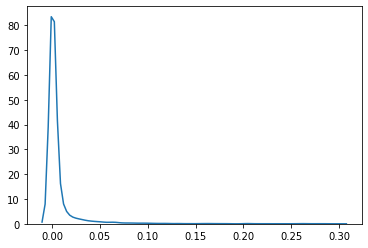

In [14]:
sns.kdeplot(pd.Series(preds.cpu().numpy().reshape(-1,)));

In [15]:
sub_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')
sub_ID['target'] = preds.cpu().numpy().reshape(-1,)
sub_ID.to_csv(Output + 'submission_ID.csv', index=False)

#画像認識モデルのみの投稿(基本はコメントアウト)
#sub.to_csv(Output + 'submission.csv', index=False)

## TableDataモデル部

In [36]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

import os

In [37]:
# config
melanoma_external_malignant_256 = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/melanoma_external_malignant_256/"
SIIM_ISIC_Melanoma_Classification = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/SIIM-ISIC-Melanoma-Classification/"
Output = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/Output/"

In [46]:
train_TD = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'train.csv')
test_TD  = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'test.csv')
sub_TD   = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')


train_TD.shape, test_TD.shape, sub_TD.shape

((33126, 8), (10982, 5), (10982, 2))

In [47]:
print(train_TD.dropna(how='any').shape)
print(test_TD.dropna(how='any').shape)

(32531, 8)
(10631, 5)


In [48]:
train_TD['sex'] = train_TD['sex'].fillna('na')
train_TD['age_approx'] = train_TD['age_approx'].fillna(-100)
train_TD['anatom_site_general_challenge'] = train_TD['anatom_site_general_challenge'].fillna('na')

test_TD['sex'] = test_TD['sex'].fillna('na')
test_TD['age_approx'] = test_TD['age_approx'].fillna(-100)
test_TD['anatom_site_general_challenge'] = test_TD['anatom_site_general_challenge'].fillna('na')

print(train_TD.dropna(how='any').shape)
print(test_TD.dropna(how='any').shape)

(33126, 8)
(10982, 5)


In [49]:
import seaborn as sns
def plot_count(df, feature, title='', size=2, rotate_axis = False):
    f, ax = plt.subplots(1,1, figsize=(3*size,2*size))
    total = float(len(df))
    sns.countplot(df[feature],order = df[feature].value_counts().index, palette='Set3')
    plt.title(title)
    if(rotate_axis):
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()

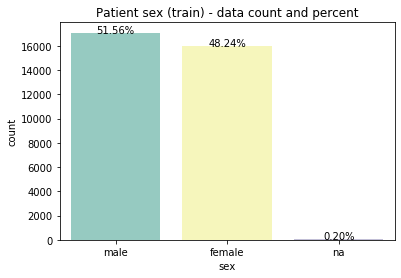

In [50]:
plot_count(train_TD, 'sex', 'Patient sex (train) - data count and percent')

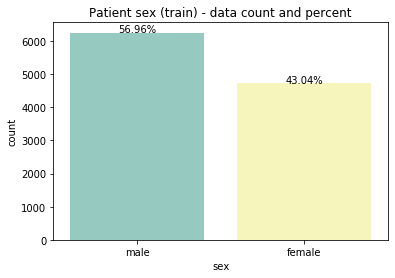

In [51]:
plot_count(test_TD, 'sex', 'Patient sex (train) - data count and percent')

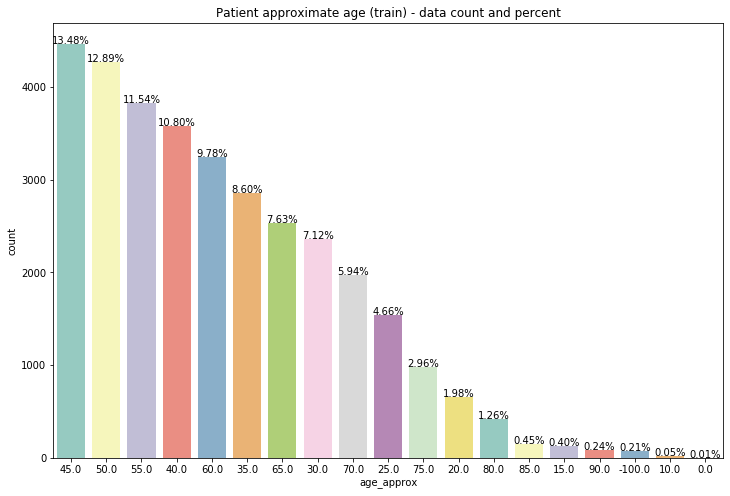

In [52]:
plot_count(train_TD, 'age_approx', 'Patient approximate age (train) - data count and percent', size=4)

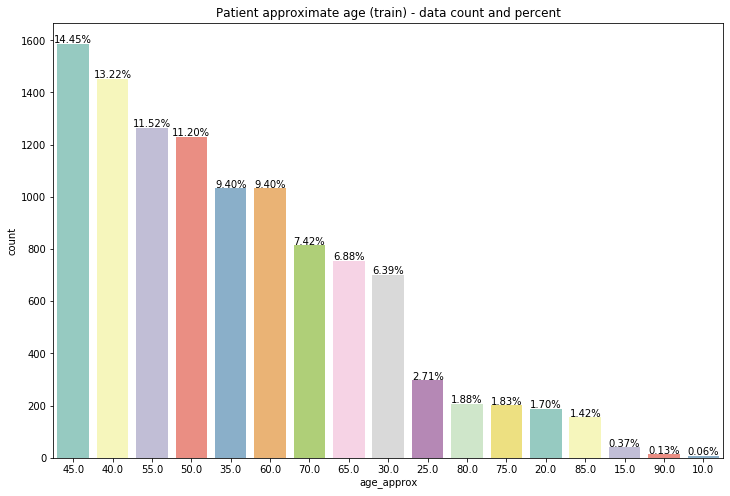

In [53]:
plot_count(test_TD, 'age_approx', 'Patient approximate age (train) - data count and percent', size=4)

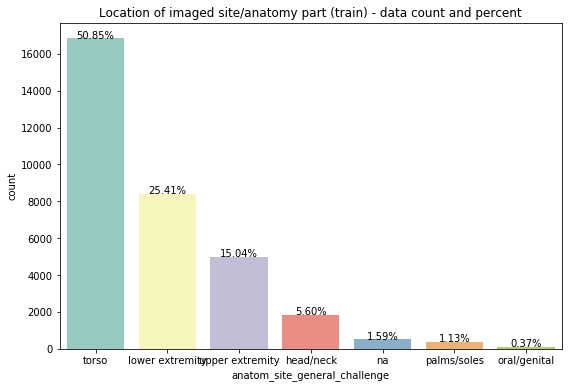

In [54]:
plot_count(train_TD, 'anatom_site_general_challenge', 'Location of imaged site/anatomy part (train) - data count and percent', size=3)

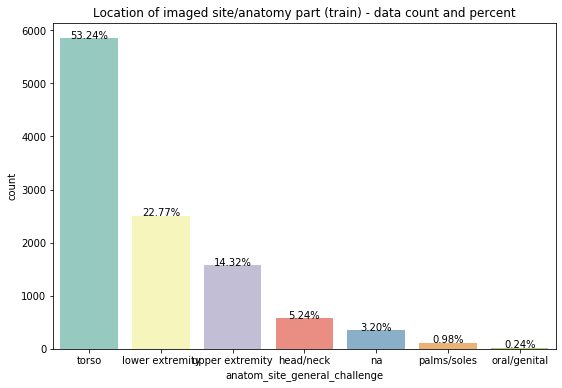

In [55]:
plot_count(test_TD, 'anatom_site_general_challenge', 'Location of imaged site/anatomy part (train) - data count and percent', size=3)

In [ ]:
def Feature_enjineering(df):
    df[]
    return df

In [19]:
train_TD.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [20]:
test_TD.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,na
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [21]:
train_TD.shape, test_TD.shape, sub_TD.shape

((33126, 8), (10982, 5), (10982, 2))

In [22]:
L = 15
feat = ['sex','age_approx','anatom_site_general_challenge']

M = train_TD.target.mean()
te = train_TD.groupby(feat)['target'].agg(['mean','count']).reset_index()
te['ll'] = ((te['mean']*te['count'])+(M*L))/(te['count']+L)
del te['mean'], te['count']

test_TD = test_TD.merge( te, on=feat, how='left' )
test_TD['ll'] = test_TD['ll'].fillna(M)

test_TD.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,ll
0,ISIC_0052060,IP_3579794,male,70.0,na,0.008530
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,0.008428
2,ISIC_0058510,IP_7960270,female,55.0,torso,0.014630
3,ISIC_0073313,IP_6375035,female,50.0,torso,0.008416
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,0.007548


In [23]:
train_TD.shape, test_TD.shape, sub_TD.shape

((33126, 8), (10982, 6), (10982, 2))

In [24]:
sub_TD.target = test_TD.ll.values
sub_TD.head(10)

,image_name,target
0,ISIC_0052060,0.008530
1,ISIC_0052349,0.008428
2,ISIC_0058510,0.014630
3,ISIC_0073313,0.008416
4,ISIC_0073502,0.007548
5,ISIC_0074618,0.013768
6,ISIC_0076801,0.022767
7,ISIC_0077586,0.013768
8,ISIC_0082004,0.015127
9,ISIC_0082785,0.018668


In [25]:
#table dataモデルのpred
sub_TD.to_csv(Output + 'submission_TD.csv', index=False)

#table dataモデルのみの投稿(基本はコメントアウトすること。)
#sub_TD.to_csv(Output + 'submission.csv', index=False)


## Ensemble部

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
image_sub = pd.read_csv(Output + 'submission_ID.csv')
tabular_sub = pd.read_csv(Output + 'submission_TD.csv')
tabular_sub.head()

,image_name,target
0,ISIC_0052060,0.008530
1,ISIC_0052349,0.008428
2,ISIC_0058510,0.014630
3,ISIC_0073313,0.008416
4,ISIC_0073502,0.007548


In [34]:
sub = image_sub.copy()
sub.target = 0.9 * image_sub.target.values + 0.1 * tabular_sub.target.values
sub.to_csv(Output + 'submission.csv', index=False)


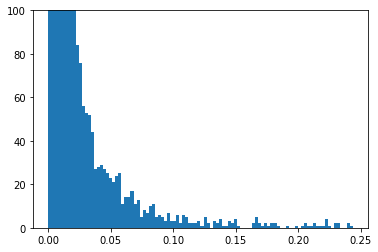

In [32]:
plt.hist(sub.target,bins=100)
plt.ylim((0,100))
plt.show()

## Submit(ここより先はkernelで入れなくて良い)

In [33]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()  # 認証を通す
csv_file_path = Output + 'submission.csv'
message = 'first submit in local (Ensemble)'
competition_id = 'siim-isic-melanoma-classification'
api.competition_submit(csv_file_path, message, competition_id)

100%|██████████| 367k/367k [00:04<00:00, 85.9kB/s] 


Successfully submitted to SIIM-ISIC Melanoma Classification